# Setting Up All Architectures

Here, I want to setup the different architectures that will be implemented and trained on SEEG data to generate predictions of seizure.

We may assume the FFT data is averaged into their electrophysiological frequency bands:
* dalpha = 0-15
* beta = 15-30
* gamma = 30-90
* high = 90-200
* hfo = 200-500

or without high/hfo if we choose to just analyze the lower frequency range activities.

1. 2D CNN on images of FFT data projected into 2D space
2. 2D CNN+LSTM on images of FFT data projected onto 2D space
3. 2D CNN+biLSTM on images of FFT data projected onto 2D space
4. 2D CNN+biLSTM+mix on images of FFt data projected onto 2D space
5. 3D CNN on images of FFT data rendered in 3D mesh
6. 3D CNN+LSTM, 3D CNN+biLSTM, 3D CNN+biLSTM+mix on images of FFT data rendered in 3D mesh

In [2]:
import sys
sys.path.append('../../dnn/')
import model.ieeg_cnn_rnn
import model.train

import processing.util as util

import time
import numpy as np
# np.random.seed(1234)
from functools import reduce
import math as m
import os

# import DNN frameworks
import tensorflow as tf
import keras

# import high level optimizers, models and layers
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import InputLayer

# for CNN
from keras.layers import Conv2D, Conv3D, MaxPooling2D, GlobalAveragePooling2D
# for RNN
from keras.layers import LSTM, TimeDistributed

# for utility functionality
from keras.layers import Input, Dense, Dropout, Flatten

from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding

# utility for datasets and training
# from keras.utils.training_utils import multi_gpu_model
from keras.datasets import imdb
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
# imports tensorflow
# from keras import backend as K

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


%load_ext autoreload
%autoreload 2

/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.callbacks import TensorBoard

tbCallBack = TensorBoard(log_dir='Graph',
                         histogram_freq=10,
                         write_graph=True,
                         write_images=True)

test = (5,)+(5,6)
print(test)
print(vgg12cnn.input_shape)

(5, 5, 6)


NameError: name 'vgg12cnn' is not defined

In [18]:
test = vgg12cnn.weights
buff = 
# test.pop()
print(test)
print(vgg12cnn.summary())

[<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 4, 32) dtype=float32_ref>, <tf.Variable 'conv2d_1/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>, <tf.Variable 'conv2d_2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>, <tf.Variable 'conv2d_3/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv2d_4/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>, <tf.Variable 'conv2d_4/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv2d_5/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'conv2d_5/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv2d_6/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'conv2d_6/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv2d_7/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'conv2d_7/bias:0' shape=(128,) dtype=float32_ref>]
_______________________________________

# 1. Build and Prototype all 2D CNN Architectures

Here, I want to build all the models that will be trained on the FFT images dataset projected into 2D space.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        1184      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        18496     
__________

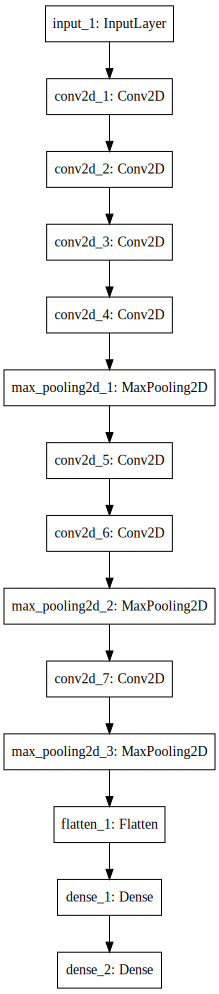

In [4]:
imsize=32
numfreqs = 4
numclasses = 2
ieegdnn = model.ieeg_cnn_rnn.IEEGdnn(imsize=imsize, 
                                     n_colors=numfreqs,
                                    num_classes=numclasses)

w_init = None
n_layers = (4,2,1)
poolsize = (2,2)
filtersize = (3,3)

size_fc = 1024
DROPOUT = False #True

# VGG-12 style later
vgg12cnn = ieegdnn._build_2dcnn(w_init=w_init, n_layers=n_layers, 
                              poolsize=poolsize, filter_size=filtersize)
vgg12cnn = ieegdnn._build_seq_output(vgg12cnn, size_fc, DROPOUT)
print(vgg12cnn.summary())

plot_model(vgg12cnn, to_file='vgg12_plot.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(vgg12cnn).create(prog='dot', format='svg'))

/Users/adam2392/Documents/dnn-unsupervised/dnn/model/ieeg_cnn_rnn.py:263: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  model.add(Merge(convnets, mode='concat'))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 640)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 128)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               71600     
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 968,114
Trainable params: 968,114
Non-trainable params: 0
_________________________________________________________________
None


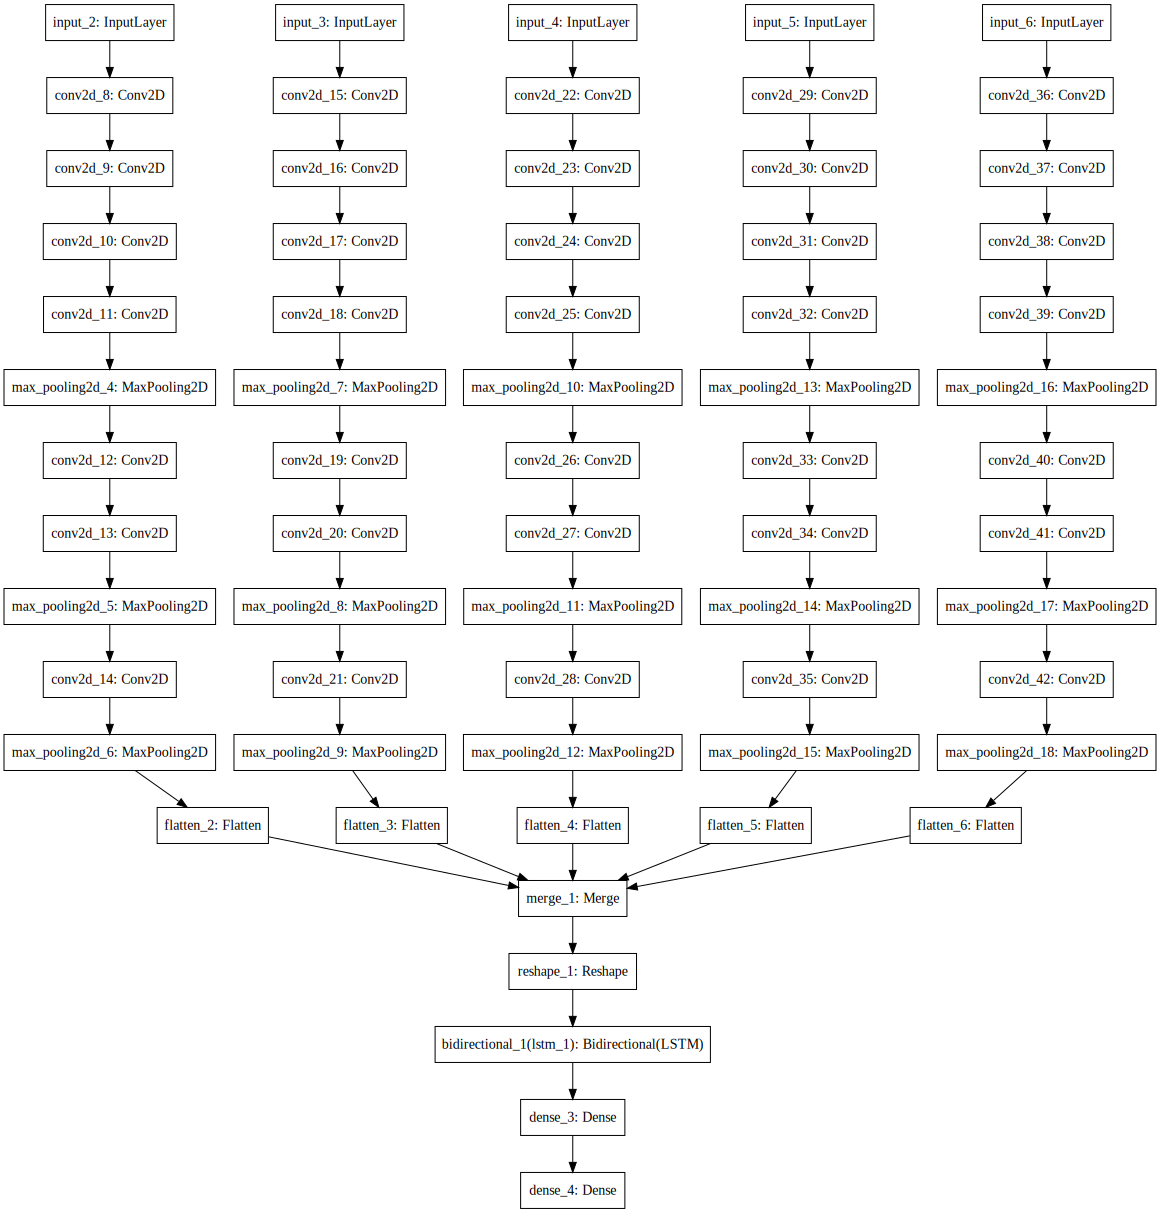

In [5]:
# load in CNN/LSTM
num_timewins = 5
size_mem = 50
size_fc = 1024
DROPOUT = False
cnn_lstm = ieegdnn.build_cnn_lstm(num_timewins=num_timewins, 
                                  size_mem=size_mem, 
                                  size_fc=size_fc, 
                                  BIDIRECT=True,
                                  DROPOUT=DROPOUT)

print(cnn_lstm.summary())
SVG(model_to_dot(cnn_lstm).create(prog='dot', format='svg'))

In [5]:
num_timewins = 5
size_mem = 128
size_fc = 1024
DROPOUT = False
cnn_same_lstm = ieegdnn.build_same_cnn_lstm(num_timewins=num_timewins, 
                                  size_mem=size_mem, 
                                  size_fc=size_fc,
                                  BIDIRECT=True,
                                  DROPOUT=DROPOUT)

print(cnn_same_lstm.input_shape)
print(cnn_same_lstm.summary())
# SVG(model_to_dot(cnn_same_lstm).create(prog='dot', format='svg'))

(None, 5, 32, 32, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 5, 128)            158208    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 686,594
Trainable params: 686,594
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
cnn_lstm_mix = ieegdnn.build_cnn_lstm_mix(num_timewins=num_timewins, 
                                  size_mem=size_mem, 
                                  size_fc=size_fc, 
                                  BIDIRECT=True,
                                  DROPOUT=DROPOUT)

print(cnn_lstm_mix.get_shape)
# print(cnn_lstm_mix.summary())
# SVG(model_to_dot(cnn_lstm_mix).create(prog='dot', format='svg'))

/Users/adam2392/Documents/dnn-unsupervised/dnn/model/ieeg_cnn_rnn.py:225: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  model.add(Merge(convnets, mode='concat'))


<bound method Tensor.get_shape of <tf.Tensor 'lstm_16/TensorArrayReadV3:0' shape=(?, 128) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'flatten_92/Reshape:0' shape=(?, ?) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'concatenate_5/concat:0' shape=(?, ?) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'dense_32/Softmax:0' shape=(?, 2) dtype=float32>>


In [19]:
# load in CNN/LSTM
imsize=32
num_timewins = 5
size_mem = 50
size_fc = 1024
DROPOUT = False
n_colors = 4

finaldir = '/Volumes/ADAM LI/pydata/dnn/output/train_v6/'
weightsfile = os.path.join(finaldir, 'final_weights.h5')
modelfile = os.path.join(finaldir, '2dcnn_model.json')

# load json and create model
json_file = open(modelfile, 'r')
loaded_model_json = json_file.read()
json_file.close()

# fixed_cnn_model = ieegdnn.load_model(weightsfile, freeze=True)
fixed_cnn_model = keras.models.model_from_json(loaded_model_json)
fixed_cnn_model.load_weights(weightsfile)

# remove the last 2 dense FC layers and freeze it
fixed_cnn_model.pop()
fixed_cnn_model.pop()
fixed_cnn_model.trainable = False

print(fixed_cnn_model.summary())
print(fixed_cnn_model.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        1184      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        18496     
__________

In [3]:
imsize=32
numfreqs = 4
numclasses = 2
ieegdnn = model.ieeg_cnn_rnn.IEEGdnn(imsize=imsize, 
                                     n_colors=numfreqs,
                                    num_classes=numclasses)

# create sequential model to get this all before the LSTM
currmodel = Sequential()
currmodel.add(TimeDistributed(fixed_cnn_model, input_shape=(num_timewins, imsize, imsize, n_colors)))
currmodel.add(LSTM(units=size_mem, 
            activation='relu', 
            return_sequences=False))
currmodel = ieegdnn._build_seq_output(currmodel, size_fc, DROPOUT=True)

currmodel = Model(inputs=currmodel.input, outputs = currmodel.output)
currmodel, config = ieegdnn.compile_model(currmodel, loss='binary_crossentropy', metrics=['accuracy']) 
print(currmodel.summary())
print(currmodel.input_shape)
print(currmodel.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1_input (In (None, 5, 32, 32, 4)      0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 512)            224256    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                112600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              52224     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total para

In [18]:
input_sequences = Input(shape=(num_timewins, imsize, imsize, n_colors))
test = TimeDistributed(fixed_cnn_model)(input_sequences)
test = LSTM(units=size_mem, 
            activation='relu', 
            return_sequences=False)(test)
predictions = Dense(2)(test)
test = Model(inputs=input_sequences, outputs=predictions)

print(test.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 5, 32, 32, 4)      0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 5, 512)            224256    
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                112600    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 102       
Total params: 336,958
Trainable params: 336,958
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
test = Sequential()
test = fixed_cnn_model
test.add(Dense(10025))
print(test.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        1184      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        18496     
__________

# a) Prepare Data For a CNN-LSTM and Misc. Functionality

- test how to load model and freeze the layers
- how to feed data into that model into the lstm


In [6]:
# load in CNN/LSTM
imsize=32
num_timewins = 5
size_mem = 50
size_fc = 1024
DROPOUT = False
n_colors = 4

finaldir = '/Volumes/ADAM LI/pydata/dnn/output/train_v6/'
weightsfile = os.path.join(finaldir, 'final_weights.h5')
modelfile = os.path.join(finaldir, '2dcnn_model.json')

# load json and create model
json_file = open(modelfile, 'r')
loaded_model_json = json_file.read()
json_file.close()

# fixed_cnn_model = ieegdnn.load_model(weightsfile, freeze=True)
fixed_cnn_model = keras.models.model_from_json(loaded_model_json)
fixed_cnn_model.load_weights(weightsfile)

# remove the last 2 dense FC layers and freeze it
fixed_cnn_model.pop()
fixed_cnn_model.pop()
fixed_cnn_model.trainable = False

print(fixed_cnn_model.summary())
print(fixed_cnn_model.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        1184      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        18496     
__________

In [7]:
# create sequential model to get this all before the LSTM
currmodel = Sequential()
currmodel.add(TimeDistributed(fixed_cnn_model, input_shape=(num_timewins, imsize, imsize, n_colors)))
currmodel.add(LSTM(units=size_mem, 
            activation='relu', 
            return_sequences=False))
currmodel = ieegdnn._build_seq_output(currmodel, size_fc, DROPOUT=True)

currmodel = Model(inputs=currmodel.input, outputs = currmodel.output)
currmodel, config = ieegdnn.compile_model(currmodel, loss='binary_crossentropy', metrics=['accuracy']) 
print(currmodel.summary())
print(currmodel.input_shape)
print(currmodel.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1_input (In (None, 5, 32, 32, 4)      0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 128)            158208    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              52224     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2050      
Total para

In [8]:
##################### INPUT DATA FOR NN ####################
traindatadir ='/Volumes/ADAM LI/pydata/dnn/traindata/'
imagedir = os.path.join(traindatadir, 'image_2d')
# get all the separate files to use for training:
datafiles = []
for root, dirs, files in os.walk(imagedir):
    for file in files:
        datafiles.append(os.path.join(root, file))
print('\nTraining on ' + str(len(datafiles)) + ' datasets!\n')


Training on 223 datasets!



In [28]:
import processing.util 

# Parameters
params = {'dim_x': imsize,
      'dim_y': imsize,
      'dim_z': numfreqs,
      'batch_size': 24,
      'shuffle': True}
datagen = processing.util.DataGenerator(**params)
training_generator = datagen.generate_fromdir(datafiles)

idx=0
for i,j in training_generator:
    
    print(i.shape)
    print(j.shape)
    
    if idx==2:
        break
    idx+=1
    break

/Volumes/ADAM LI/pydata/dnn/traindata/image_2d/allregions_moved/id001_ac_nez1_npz1_0.npz
(239, 32, 32, 4)
(239, 2)
9
[127  83 161  20 131   7 117  26 147 216 143  41  42 151  49 181 169 101
 224 186 128  66 133 184 225   6 105 164  10  48  31  91 208 109  28 121
  64 102 197   2 222 126 100  98 207   9  23 153  80 125  12  18 210  97
 130 148  39   3  25  60 182 165  13  38 163 215 228 238  11 145  61 234
   4 236 103  44 212 136 233 232  99 185 141 168  75 204  90  85 237  81
 106  65  16  15 193 220 119  79 144  86 160   5 116  14 226 113 175 162
  84 200  22 196  40  17 187 223 217 227  50 134 111 231 170  51 172  88
 202 167 199  87  29 135 137  92 110  21  36 214  56   1  57 108 190 156
  89   8  59  93 122 219  69  58 178  32 146 229 180 174  45  72 120 218
  47  67 183 173 203 230   0  74 104 201  94  19  96 177 158  33 211 149
  37  71  53 118 140 159 221  76 195  95 112 107 154  43 114 115 142 124
 213  35 209  62 179  73 129 150 188  78  77 166  68  34  82 138 189  55
 191 12

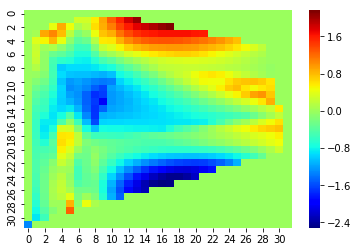

In [26]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.heatmap(i[0,:,:,0].squeeze(), cmap='jet')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
# (X_train, y_train), (X_val, y_val), (X_test, y_test) = datahandler.reformatinput(images, labels)
X_train, X_test = train_test_split(datafiles, test_size=0.33, random_state=42)
  
print(len(datafiles))
print(len(X_train))
print(len(X_test))


223
149
74


# b) Load Sample Data And See How That Fits Into Input

Need to test how image tensors are fed into the neural networks.

In [23]:
import os
datadir = '/Volumes/ADAM LI/pydata/dnn/traindata/image_2d/'

datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        datafiles.append(os.path.join(root, file))
print('\nTraining on ' + str(len(datafiles)) + ' datasets!\n')
print(datafiles[0:5])


Training on 223 datasets!

['/Volumes/ADAM LI/pydata/dnn/traindata/image_2d/allregions_moved/id001_ac_nez1_npz1_0.npz', '/Volumes/ADAM LI/pydata/dnn/traindata/image_2d/allregions_moved/id001_ac_nez1_npz1_1.npz', '/Volumes/ADAM LI/pydata/dnn/traindata/image_2d/allregions_moved/id001_ac_nez1_npz1_2.npz', '/Volumes/ADAM LI/pydata/dnn/traindata/image_2d/allregions_moved/id001_ac_nez1_npz1_3.npz', '/Volumes/ADAM LI/pydata/dnn/traindata/image_2d/allregions_moved/id001_ac_nez1_npz1_4.npz']


In [20]:
print("1st dim = batches/samples\n\
       2nd dim = time dim\n\
       3rd dim = W\n\
       4th dim = H\n\
       5th dim = band")
print(cnn_same_lstm.input)


1st dim = batches/samples
       2nd dim = time dim
       3rd dim = W
       4th dim = H
       5th dim = band
Tensor("time_distributed_1_input:0", shape=(?, 5, 32, 32, 4), dtype=float32)


In [25]:
maxlen = 0
for datafile in datafiles:
    data = np.load(datafile)
    image_tensor = data['image_tensor']
    metadata = data['metadata'].item()
    
    maxlen = max(maxlen, image_tensor.shape[0])
    
print(image_tensor.shape)
print(metadata.keys())
print(maxlen)
maxlen = 500
newimage_seq = keras.preprocessing.sequence.pad_sequences(test, maxlen=500, 
        dtype='float64', padding='pre', truncating='pre', value=0.)


(359, 4, 32, 32)
dict_keys(['x0ez', 'seeg_contacts', 'new_locs', 'ylabels'])
439


In [30]:
# the training data dir
traindatadir = '/Volumes/ADAM LI/pydata/dnn/traindata/finaldata/'
filename = os.path.join(traindatadir, 'allimages_2d.npz')
data = np.load(filename)
images = data['images']
print(images.shape)

(59585, 4096)


In [33]:
test = images.reshape((-1, 4, 32, 32))
print(test.shape)

(59585, 4, 32, 32)


In [133]:
print(x_train.shape)
print(y_train.shape)
print(x_train[0])
print(y_train[0])

(25000,)
(25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


In [ ]:

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# 2. Building Architectures for 3D CNN

Build the CNN, CNN+LSTM, CNN+BidirectLSTM, CNN+BidirectLSTM+mix

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 32, 4)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 30, 30, 30, 32)    3488      
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 28, 28, 28, 32)    27680     
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 26, 26, 26, 32)    27680     
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 24, 24, 24, 32)    27680     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 12, 12, 12, 32)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 10, 10, 64)    55360     
__________

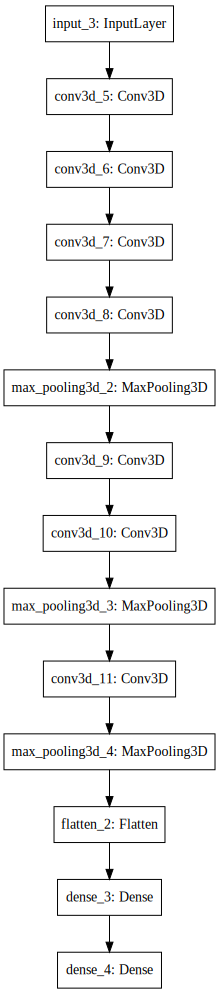

In [6]:
w_init = None
n_layers = (4,2,1)
poolsize = (2,2,2)
filtersize = (3,3,3)
size_fc = 1024
DROPOUT = False #True

# VGG-12 style later
vgg12cnn = ieegdnn._build_3dcnn(w_init=w_init, n_layers=n_layers, 
                              poolsize=poolsize, filter_size=filtersize)
vgg12cnn = ieegdnn._build_seq_output(vgg12cnn, size_fc, DROPOUT)
print(vgg12cnn.summary())
SVG(model_to_dot(vgg12cnn).create(prog='dot', format='svg'))

In [16]:
# load in CNN/LSTM
num_timewins = 5
size_mem = 128
size_fc = 1024
DROPOUT = False
# code up 3D CNN+LSTM, CNN+LSTMmix and get outputs
cnn_same_lstm = ieegdnn.build_same_cnn_lstm(num_timewins=num_timewins, 
                                  size_mem=size_mem, 
                                  size_fc=size_fc,
                                  dim=3,
                                  BIDIRECT=True,
                                  DROPOUT=DROPOUT)

print(cnn_same_lstm.summary())
SVG(model_to_dot(cnn_same_lstm).create(prog='dot', format='svg'))

cnn_lstm_mix = ieegdnn.build_cnn_lstm_mix(num_timewins=num_timewins, 
                                  size_mem=size_mem, 
                                  size_fc=size_fc, 
                                  dim=3,
                                  BIDIRECT=True,
                                  DROPOUT=DROPOUT)

print(type(cnn_lstm_mix))
print


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 5, 128)            473856    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 2050      
Total params: 1,002,242
Trainable params: 1,002,242
Non-trainable params: 0
_________________________________________________________________
None


/Users/adam2392/Documents/dnn-unsupervised/dnn/model/ieeg_cnn_rnn.py:296: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  num_cnn_features = convnets[0].output_shape[1]


<class 'keras.engine.training.Model'>


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 32, 32, 32, 4 0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 32, 32, 32, 4 0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 32, 32, 32, 4 0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 32, 32, 32, 4 0                                            
__________________________________________________________________________________________________
input_19 (

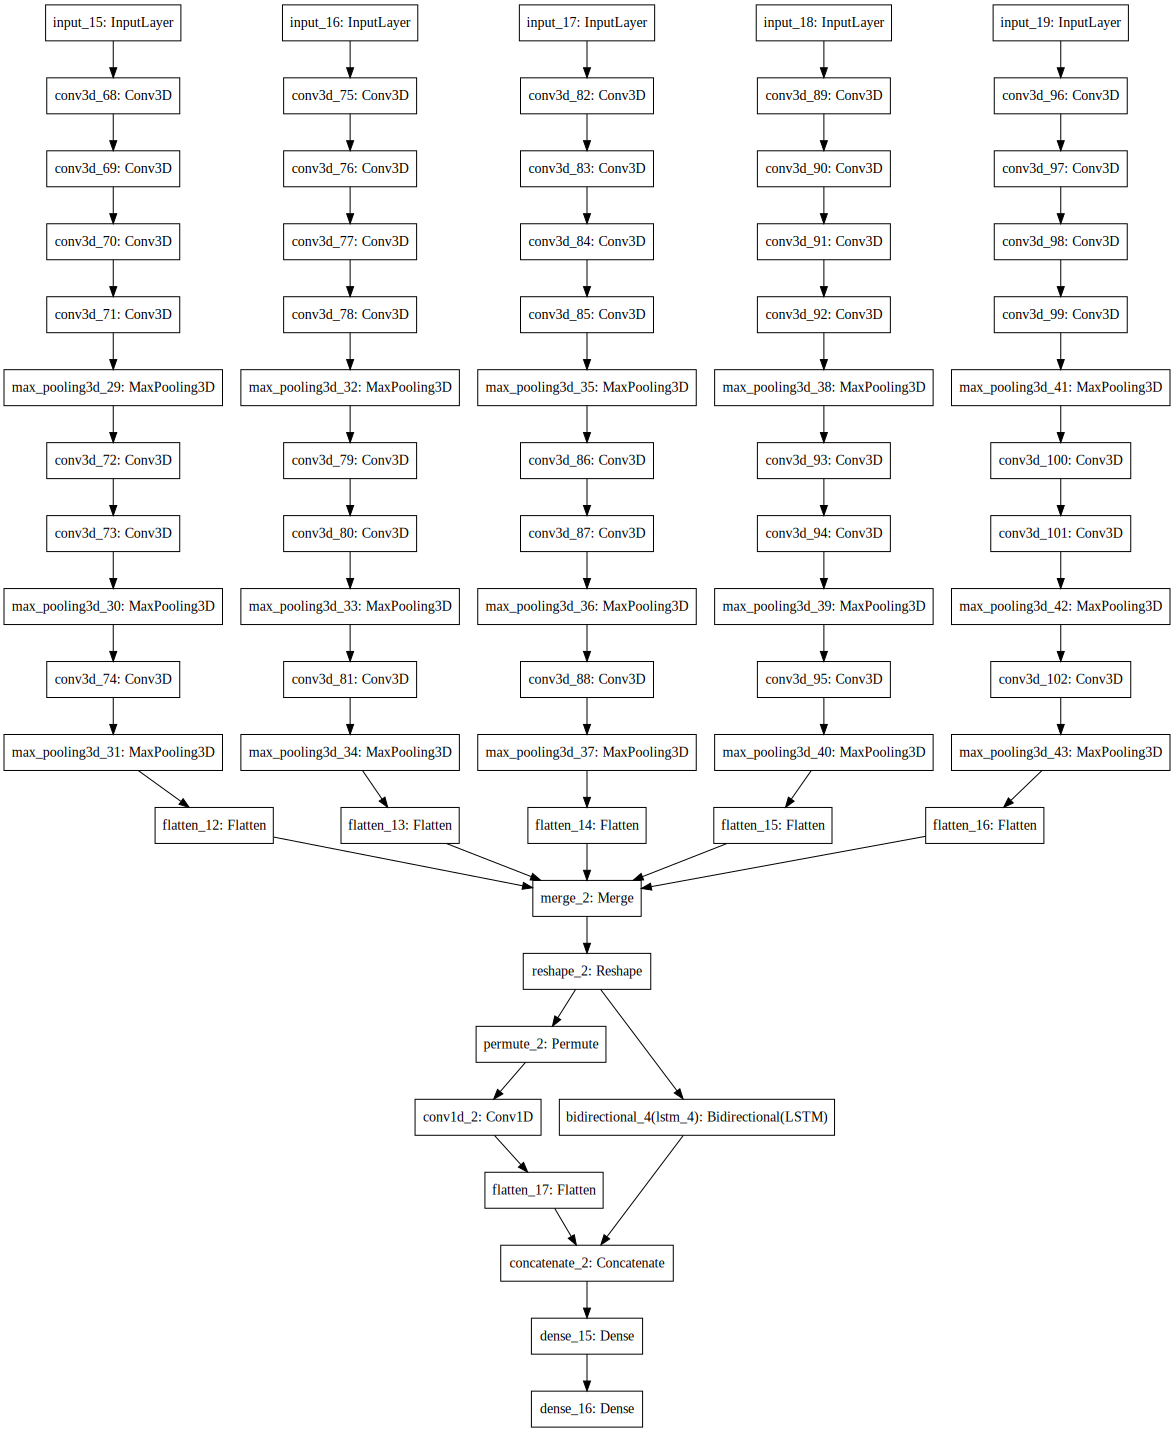

In [18]:
print(cnn_lstm_mix.summary())
SVG(model_to_dot(cnn_lstm_mix).create(prog='dot', format='svg'))


# 3. Build Up Some PreBuilt Keras Models

Import VGG and certain architectures that already have pretrained weights.

I will test say... VGG16, InceptionV3 and Xception

In [23]:
from keras.applications import VGG16, VGG19, MobileNet, Xception, InceptionV3
from keras.models import Model

In [15]:
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [19]:
# create the base pre-trained model
base_model = VGG19(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

80142336/80134624 [==============================] - 19s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_poo

In [22]:
# create the base pre-trained model
base_model = MobileNet(input_shape=(128,128,3), weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

17227776/17225924 [==============================] - 4s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_r

In [24]:
# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

83689472/83683744 [==============================] - 23s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_22[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________

In [26]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

print(model.summary())

87916544/87910968 [==============================] - 53s 1us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, None, None, 3 864         input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, None, None, 3 96          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_5[0][0]      
___________________________________________